In [1]:
# ! pip install kaggle

In [2]:
# ! mkdir ~/.kaggle

In [3]:
# ! cp kaggle.json ~/.kaggle/

In [4]:
# ! chmod 600 ~/.kaggle/kaggle.json


In [5]:
# !kaggle competitions download -c deep-learning-spring-2025-project-2

In [6]:
# ! unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


Using device: cuda
Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Example data:
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 2
--------------------------------------------------
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label: 2
--------------------------------------------------
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the dep

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,812 || all params: 125,536,520 || trainable%: 0.7072
Starting training...

Epoch 1/3


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

Train Loss: 0.4913, Train Accuracy: 0.7994
Test Loss: 0.2567, Test Accuracy: 0.9157
--------------------------------------------------
Epoch 2/3


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

Train Loss: 0.2490, Train Accuracy: 0.9162
Test Loss: 0.2378, Test Accuracy: 0.9209
--------------------------------------------------
Epoch 3/3


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

Train Loss: 0.2367, Train Accuracy: 0.9197
Test Loss: 0.2332, Test Accuracy: 0.9232
--------------------------------------------------

Final Test Accuracy: 0.9232
Total number of trainable parameters: 887812


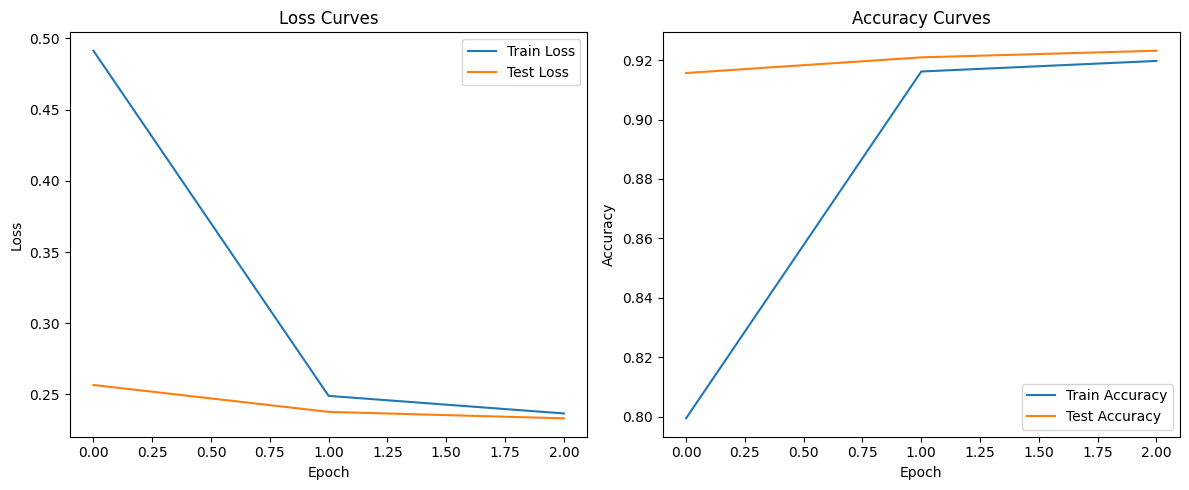


Predictions on sample texts:
Text: Oil prices hit a record high as tensions rise in the Middle East.
Predicted class: Business

Text: Manchester United wins 3-0 against Liverpool in Premier League clash.
Predicted class: Sports

Text: Apple announces new iPhone with revolutionary features at annual event.
Predicted class: Sci/Tech

Text: Scientists discover breakthrough in quantum computing research.
Predicted class: Sci/Tech

Model saved to roberta_lora_agnews

Training Summary:
Final Test Accuracy: 0.9232
Total Number of Trainable Parameters: 887812
✅ Parameter count is within the limit (<=1M)!


In [2]:
# Install necessary packages
!pip install -q transformers datasets peft torchsummary

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, get_linear_schedule_with_warmup, AutoModel, AutoConfig
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the AG News dataset
agnews = load_dataset("ag_news")
print(f"Dataset loaded: {agnews}")

# Display some examples from the training set
print("\nExample data:")
for i in range(3):
    print(f"Text: {agnews['train'][i]['text']}")
    print(f"Label: {agnews['train'][i]['label']}")
    print("-" * 50)

# Define the class names for AG News
class_names = ["World", "Sports", "Business", "Sci/Tech"]

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Set max sequence length
MAX_LENGTH = 128

# Create a dataset class for AG News
class AGNewsDataset(Dataset):
    def __init__(self, split="train", max_length=MAX_LENGTH):
        self.data = agnews[split]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Remove the batch dimension
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create train and validation datasets
train_dataset = AGNewsDataset(split="train")
test_dataset = AGNewsDataset(split="test")

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class RobertaClassifier(nn.Module):
    def __init__(self, model_name="roberta-base", num_classes=4):
        super(RobertaClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.roberta = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        **kwargs
    ):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            **kwargs
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize the model
model = RobertaClassifier(num_classes=4)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,  # Rank of the update matrices
    lora_alpha=32,  # Alpha parameter for LoRA scaling
    lora_dropout=0.1,  # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"],  # Apply LoRA to attention layers only
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

# Move model to device
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Calculate number of training steps
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)

# Create scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Training function
def train(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        progress_bar.set_postfix({
            "loss": total_loss / (progress_bar.n + 1),
            "accuracy": total_correct / total_samples
        })

    return total_loss / len(dataloader), total_correct / total_samples

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy

# Training loop
print("Starting training...\n")

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-" * 50)

# Print final test accuracy
print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.4f}")

# Get and print the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_trainable_params = count_parameters(model)
print(f"Total number of trainable parameters: {total_trainable_params}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.savefig("training_history.png")
plt.show()

# Test on a few examples
test_examples = [
    "Oil prices hit a record high as tensions rise in the Middle East.",
    "Manchester United wins 3-0 against Liverpool in Premier League clash.",
    "Apple announces new iPhone with revolutionary features at annual event.",
    "Scientists discover breakthrough in quantum computing research."
]

def predict_class(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(logits, dim=1).item()

    return class_names[pred]

print("\nPredictions on sample texts:")
for text in test_examples:
    predicted_class = predict_class(text, model, tokenizer, device)
    print(f"Text: {text}\nPredicted class: {predicted_class}\n")

# Save model to specified output directory
output_dir = "roberta_lora_agnews"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

# Print final summary
print("\nTraining Summary:")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Total Number of Trainable Parameters: {total_trainable_params}")

# Verify parameters are under 1 million
if total_trainable_params <= 1000000:
    print("✅ Parameter count is within the limit (<=1M)!")
else:
    print("❌ Parameter count exceeds the limit (>1M). Need to reduce parameters.")

In [25]:
import torch
import pandas as pd
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModel
from peft import PeftModel, PeftConfig
import torch.nn as nn

# === Configuration ===
MODEL_PATH = "/content/roberta_lora_agnews"
TEST_PATH = "/content/test_unlabelled.pkl"
SUBMISSION_PATH = "/content/submission.csv"
MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# === Define your original RobertaClassifier ===
class RobertaClassifier(nn.Module):
    def __init__(self, model_name="roberta-base", num_classes=4):
        super(RobertaClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.roberta = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        **kwargs
    ):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            **kwargs
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# === Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# === Restore the exact model architecture used during training
base_model = RobertaClassifier(num_classes=NUM_CLASSES)

# === Apply LoRA adapter on top of your custom classifier
model = PeftModel.from_pretrained(base_model, MODEL_PATH).to(device).eval()

# === Load test data
with open(TEST_PATH, "rb") as f:
    test_data = pickle.load(f)

print(f"✅ Loaded test data with {len(test_data)} samples")

# === Define test dataset class
class UnlabeledTestDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]["text"]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "index": idx
        }

# === Create dataloader
test_dataset = UnlabeledTestDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === Run predictions
all_preds = []
all_indices = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating predictions"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        indices = batch["index"]

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().tolist()

        all_preds.extend(preds)
        all_indices.extend([int(i) for i in indices])

# === Create submission.csv
submission_df = pd.DataFrame({
    "index": all_indices,
    "label": all_preds
}).sort_values("index")

submission_df.to_csv(SUBMISSION_PATH, index=False)
print(f"✅ submission.csv saved to {SUBMISSION_PATH}")


✅ Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded test data with 8000 samples


Generating predictions: 100%|██████████| 250/250 [00:56<00:00,  4.43it/s]

✅ submission.csv saved to /content/submission.csv


In [27]:
df = pd.read_csv('/content/submission.csv')
df.rename(columns={'index': 'ID', 'label': 'Label'}, inplace=True)

In [28]:
df.to_csv('updated_file.csv', index=False)